# Libraries

In [1]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(27)

# Dataset

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
BASE_DIR = "../input/cifar10-python/cifar-10-batches-py"

In [6]:
data = np.empty((0, 3072))
labels = []
for i in range(1,6):
    path = os.path.join(BASE_DIR, f"data_batch_{i}")
    dict = unpickle(path)
    data = np.vstack((data, dict[b'data']))
    labels.extend(dict[b'labels'])

In [7]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=42)

In [8]:
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = np.transpose(data.reshape(data.shape[0], 3, 32, 32), (0, 2, 3, 1))/255
        
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.data[idx])
        else:
            image = torch.tensor(self.data[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [9]:
transform_train = transforms.Compose(
                [
                    
                    transforms.ToTensor(),
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomCrop(32),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

In [10]:
train_dataset = CifarDataset(train_data, train_labels, transform_train)
valid_dataset = CifarDataset(valid_data, valid_labels, transform_test)

In [11]:
def show_img(x):
    img, label = x
    print(label)
    plt.imshow(torch.permute(img, (1,2,0)))

tensor(1)


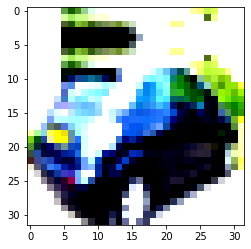

In [12]:
show_img(train_dataset[900])

In [13]:
path = os.path.join(BASE_DIR, f"test_batch")
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']

In [14]:
test_dataset = CifarDataset(data, labels, transform_test)

# Model

In [15]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=False)

model = WideResNet(16, 10, 1)
model.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [18]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train()
    start = end = time.time()
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg

def valid_fn(test_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.eval()
    start = end = time.time()
    preds = []
    valid_labels = []
    for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        preds.append(y_preds.softmax(1).to('cpu').numpy())
        valid_labels.append(labels.to('cpu').numpy())
        
        batch_time.update(time.time() - end)
        end = time.time()

    predictions = np.concatenate(preds)
    valid_labels = np.concatenate(valid_labels)
    
    score = get_score(valid_labels, predictions.argmax(1))
    
    return losses.avg, score

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=0.0005, nesterov=True)
#optimizer = AdamW(model.parameters(), lr=1e-3)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True, eps=1e-6)
#scheduler = CosineAnnealingLR(optimizer, T_max=15000, eta_min=1e-6, last_epoch=-1)
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5, last_epoch=-1, verbose=True)
scheduler = MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [20]:
best_score = 0

for epoch in range(200):
    start_time = time.time()
    
    avg_loss = train_fn(train_loader, model, criterion, optimizer, None, device)
    avg_val_loss, score = valid_fn(valid_loader, model, criterion, device)

    scheduler.step()
    
    print(f"Epoch {epoch+1}")
    print(f"Accuracy: {score} | Train loss: {avg_loss} | Valid loss: {avg_val_loss}")
    
    if score > best_score:
        print("YES")
        best_score = score
        torch.save(model.state_dict(), f"best_model.pt")
        
    elapsed = time.time() - start_time

100%|██████████| 40/40 [00:01<00:00, 39.75it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1
Accuracy: 0.5026 | Train loss: 1.4495093865288629 | Valid loss: 1.486290304374695
YES



100%|██████████| 40/40 [00:00<00:00, 50.79it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2
Accuracy: 0.6566 | Train loss: 1.0153448535283407 | Valid loss: 0.9566788623809814
YES



100%|██████████| 40/40 [00:00<00:00, 45.20it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3
Accuracy: 0.6376 | Train loss: 0.868682567914327 | Valid loss: 1.05019693069458



100%|██████████| 40/40 [00:00<00:00, 52.40it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4
Accuracy: 0.6624 | Train loss: 0.7737999092737834 | Valid loss: 1.0634279424667359
YES



100%|██████████| 40/40 [00:00<00:00, 50.87it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5
Accuracy: 0.698 | Train loss: 0.7078453761312696 | Valid loss: 0.9283505885124207
YES



100%|██████████| 40/40 [00:00<00:00, 52.43it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6
Accuracy: 0.7342 | Train loss: 0.6656932672500611 | Valid loss: 0.7668421933412551
YES



100%|██████████| 40/40 [00:00<00:00, 54.16it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7
Accuracy: 0.686 | Train loss: 0.6379145861201816 | Valid loss: 1.0234578406333923



100%|██████████| 40/40 [00:00<00:00, 54.60it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8
Accuracy: 0.7302 | Train loss: 0.6122625700738695 | Valid loss: 0.8059400720119476



100%|██████████| 40/40 [00:00<00:00, 55.81it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9
Accuracy: 0.7442 | Train loss: 0.5947742824024624 | Valid loss: 0.7669322040557861
YES



100%|██████████| 40/40 [00:00<00:00, 43.30it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10
Accuracy: 0.7794 | Train loss: 0.5797425578223334 | Valid loss: 0.6429370448112488
YES



100%|██████████| 40/40 [00:00<00:00, 53.20it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 11
Accuracy: 0.7788 | Train loss: 0.5647153880225287 | Valid loss: 0.6329432119846344



100%|██████████| 40/40 [00:00<00:00, 42.58it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 12
Accuracy: 0.7778 | Train loss: 0.557655354086558 | Valid loss: 0.6426013116836548



100%|██████████| 40/40 [00:00<00:00, 53.35it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 13
Accuracy: 0.7498 | Train loss: 0.5494405351956685 | Valid loss: 0.743491760969162



100%|██████████| 40/40 [00:00<00:00, 54.97it/s]


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 14
Accuracy: 0.7768 | Train loss: 0.5454499301539527 | Valid loss: 0.6829834358215332


100%|██████████| 40/40 [00:00<00:00, 56.76it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 15
Accuracy: 0.7694 | Train loss: 0.5351006974220276 | Valid loss: 0.7107941106200218



100%|██████████| 40/40 [00:00<00:00, 55.07it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 16
Accuracy: 0.7648 | Train loss: 0.5234588458802965 | Valid loss: 0.6680755876541138



100%|██████████| 40/40 [00:00<00:00, 54.67it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 17
Accuracy: 0.762 | Train loss: 0.5215659145832062 | Valid loss: 0.7280081638336182



100%|██████████| 40/40 [00:00<00:00, 48.69it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 18
Accuracy: 0.7688 | Train loss: 0.5218952222665151 | Valid loss: 0.7156791565895081



100%|██████████| 40/40 [00:00<00:00, 53.04it/s]


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 19
Accuracy: 0.7926 | Train loss: 0.5099890420489841 | Valid loss: 0.6453797723770142
YES


100%|██████████| 40/40 [00:00<00:00, 53.22it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 20
Accuracy: 0.7608 | Train loss: 0.511964723247952 | Valid loss: 0.7070232090473175



100%|██████████| 40/40 [00:00<00:00, 44.17it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 21
Accuracy: 0.7318 | Train loss: 0.5055853843635983 | Valid loss: 0.8112730377197266



100%|██████████| 40/40 [00:00<00:00, 54.33it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 22
Accuracy: 0.7434 | Train loss: 0.5071159510824416 | Valid loss: 0.7953812432765961



100%|██████████| 40/40 [00:00<00:00, 53.91it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 23
Accuracy: 0.8106 | Train loss: 0.49759769644737245 | Valid loss: 0.549844745349884
YES



100%|██████████| 40/40 [00:00<00:00, 53.53it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 24
Accuracy: 0.7584 | Train loss: 0.49169962785508897 | Valid loss: 0.7319248791694641



100%|██████████| 40/40 [00:00<00:00, 45.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 25
Accuracy: 0.7662 | Train loss: 0.4978996207078298 | Valid loss: 0.6969424018025399



100%|██████████| 40/40 [00:00<00:00, 55.36it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 26
Accuracy: 0.745 | Train loss: 0.4945538312594096 | Valid loss: 0.7884390766143798



100%|██████████| 40/40 [00:01<00:00, 39.96it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 27
Accuracy: 0.7496 | Train loss: 0.487344394270579 | Valid loss: 0.7684281224250793



100%|██████████| 40/40 [00:00<00:00, 54.43it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 28
Accuracy: 0.7278 | Train loss: 0.4911845747417874 | Valid loss: 0.8677455419540405



100%|██████████| 40/40 [00:01<00:00, 38.76it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 29
Accuracy: 0.7152 | Train loss: 0.48698841053644815 | Valid loss: 0.9040451547622681



100%|██████████| 40/40 [00:00<00:00, 52.15it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 30
Accuracy: 0.7986 | Train loss: 0.48408010919358996 | Valid loss: 0.641887382888794



100%|██████████| 40/40 [00:00<00:00, 42.37it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 31
Accuracy: 0.7888 | Train loss: 0.4838890838093228 | Valid loss: 0.6323953763008118



100%|██████████| 40/40 [00:00<00:00, 50.02it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 32
Accuracy: 0.8128 | Train loss: 0.47829697953330147 | Valid loss: 0.5542326350688934
YES



100%|██████████| 40/40 [00:00<00:00, 46.36it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 33
Accuracy: 0.772 | Train loss: 0.47731587789853414 | Valid loss: 0.6925331876277924



100%|██████████| 40/40 [00:01<00:00, 35.72it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 34
Accuracy: 0.7752 | Train loss: 0.4771497894710965 | Valid loss: 0.6651523271560669



100%|██████████| 40/40 [00:00<00:00, 54.61it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 35
Accuracy: 0.8172 | Train loss: 0.47193689822620816 | Valid loss: 0.5537258712768555
YES



100%|██████████| 40/40 [00:01<00:00, 36.21it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 36
Accuracy: 0.809 | Train loss: 0.47566900219387476 | Valid loss: 0.5642580108642579



100%|██████████| 40/40 [00:00<00:00, 47.19it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 37
Accuracy: 0.8086 | Train loss: 0.47049421316782636 | Valid loss: 0.5455667497634887



100%|██████████| 40/40 [00:00<00:00, 56.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 38
Accuracy: 0.7938 | Train loss: 0.4749697942097982 | Valid loss: 0.6203977754592895



100%|██████████| 40/40 [00:00<00:00, 50.45it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 39
Accuracy: 0.8012 | Train loss: 0.4686843867407905 | Valid loss: 0.5924330470561981



100%|██████████| 40/40 [00:00<00:00, 54.25it/s]


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 40
Accuracy: 0.8214 | Train loss: 0.4713969148053063 | Valid loss: 0.5275712123870849
YES


100%|██████████| 40/40 [00:00<00:00, 41.81it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 41
Accuracy: 0.7894 | Train loss: 0.46796858846876355 | Valid loss: 0.6150790941238403



100%|██████████| 40/40 [00:00<00:00, 54.88it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 42
Accuracy: 0.7646 | Train loss: 0.4615986294057634 | Valid loss: 0.7847230331420898



100%|██████████| 40/40 [00:00<00:00, 43.91it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 43
Accuracy: 0.8282 | Train loss: 0.46406560044818457 | Valid loss: 0.508256595993042
YES



100%|██████████| 40/40 [00:00<00:00, 51.70it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 44
Accuracy: 0.821 | Train loss: 0.45944402979744803 | Valid loss: 0.5261402698516846



100%|██████████| 40/40 [00:01<00:00, 35.66it/s]


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 45
Accuracy: 0.7832 | Train loss: 0.4623273043367598 | Valid loss: 0.6385251477241516


100%|██████████| 40/40 [00:00<00:00, 52.92it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 46
Accuracy: 0.7562 | Train loss: 0.4662418238745795 | Valid loss: 0.7646388862609863



100%|██████████| 40/40 [00:01<00:00, 39.09it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 47
Accuracy: 0.7938 | Train loss: 0.4642346607791053 | Valid loss: 0.604618250656128



100%|██████████| 40/40 [00:00<00:00, 51.69it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 48
Accuracy: 0.8274 | Train loss: 0.4592224192831251 | Valid loss: 0.5028337138175965



100%|██████████| 40/40 [00:00<00:00, 53.40it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 49
Accuracy: 0.7378 | Train loss: 0.46126069815953574 | Valid loss: 0.8663411283493042



100%|██████████| 40/40 [00:00<00:00, 53.09it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 50
Accuracy: 0.785 | Train loss: 0.4634785329818726 | Valid loss: 0.6534760097980499



100%|██████████| 40/40 [00:00<00:00, 41.44it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 51
Accuracy: 0.7992 | Train loss: 0.459603162293964 | Valid loss: 0.5752428711891174



100%|██████████| 40/40 [00:00<00:00, 53.54it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 52
Accuracy: 0.777 | Train loss: 0.4548926952997843 | Valid loss: 0.7004448421478271



100%|██████████| 40/40 [00:00<00:00, 44.15it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 53
Accuracy: 0.7902 | Train loss: 0.45673862783643937 | Valid loss: 0.6639731442451478



100%|██████████| 40/40 [00:00<00:00, 54.88it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 54
Accuracy: 0.7842 | Train loss: 0.4530407605701023 | Valid loss: 0.6738141328811645



100%|██████████| 40/40 [00:00<00:00, 52.33it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 55
Accuracy: 0.8018 | Train loss: 0.4544766135215759 | Valid loss: 0.5689631460189819



100%|██████████| 40/40 [00:00<00:00, 40.78it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 56
Accuracy: 0.7524 | Train loss: 0.45116834101147124 | Valid loss: 0.7847071577548981



100%|██████████| 40/40 [00:01<00:00, 38.17it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 57
Accuracy: 0.7706 | Train loss: 0.454147984096739 | Valid loss: 0.6732236185073852



100%|██████████| 40/40 [00:00<00:00, 53.30it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 58
Accuracy: 0.7312 | Train loss: 0.4554653829680549 | Valid loss: 0.8109078568458558



100%|██████████| 40/40 [00:00<00:00, 53.74it/s]


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 59
Accuracy: 0.783 | Train loss: 0.44793866662979126 | Valid loss: 0.6517607931137085


100%|██████████| 40/40 [00:00<00:00, 40.86it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 60
Accuracy: 0.8168 | Train loss: 0.45049413623809814 | Valid loss: 0.5512191853284836



100%|██████████| 40/40 [00:00<00:00, 55.24it/s]


Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 61
Accuracy: 0.884 | Train loss: 0.3170782325691647 | Valid loss: 0.33140099165439607
YES


100%|██████████| 40/40 [00:00<00:00, 52.55it/s]


Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 62
Accuracy: 0.8866 | Train loss: 0.28371066607369316 | Valid loss: 0.3565457034111023
YES


100%|██████████| 40/40 [00:00<00:00, 52.34it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 63
Accuracy: 0.8864 | Train loss: 0.2682135321988 | Valid loss: 0.33064774075746534



100%|██████████| 40/40 [00:00<00:00, 55.93it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 64
Accuracy: 0.8916 | Train loss: 0.26011608179940116 | Valid loss: 0.3126217621803284
YES



100%|██████████| 40/40 [00:00<00:00, 51.66it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 65
Accuracy: 0.8878 | Train loss: 0.2580221686681112 | Valid loss: 0.3479215802669525



100%|██████████| 40/40 [00:00<00:00, 52.31it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 66
Accuracy: 0.8816 | Train loss: 0.25466409468121 | Valid loss: 0.3532939806163311



100%|██████████| 40/40 [00:00<00:00, 57.12it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 67
Accuracy: 0.8702 | Train loss: 0.26095399271647135 | Valid loss: 0.3762756489753723



100%|██████████| 40/40 [00:00<00:00, 53.94it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 68
Accuracy: 0.8806 | Train loss: 0.2542880636374156 | Valid loss: 0.35734562684893606



100%|██████████| 40/40 [00:00<00:00, 55.55it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 69
Accuracy: 0.891 | Train loss: 0.2532240542226368 | Valid loss: 0.3192348243713379



100%|██████████| 40/40 [00:00<00:00, 55.06it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 70
Accuracy: 0.8728 | Train loss: 0.2537283594555325 | Valid loss: 0.3886993496417999



100%|██████████| 40/40 [00:00<00:00, 50.33it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 71
Accuracy: 0.8746 | Train loss: 0.25192222896946803 | Valid loss: 0.3681177474975586



100%|██████████| 40/40 [00:00<00:00, 41.08it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 72
Accuracy: 0.8864 | Train loss: 0.25435128690136805 | Valid loss: 0.36018012409210204



100%|██████████| 40/40 [00:01<00:00, 24.13it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 73
Accuracy: 0.8736 | Train loss: 0.2551298613230387 | Valid loss: 0.3761249904632568



100%|██████████| 40/40 [00:00<00:00, 54.46it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 74
Accuracy: 0.8764 | Train loss: 0.2533296906153361 | Valid loss: 0.37705772276893257



100%|██████████| 40/40 [00:00<00:00, 46.36it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 75
Accuracy: 0.8862 | Train loss: 0.256161226855384 | Valid loss: 0.33393504350185393



100%|██████████| 40/40 [00:00<00:00, 50.24it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 76
Accuracy: 0.8592 | Train loss: 0.2573918005466461 | Valid loss: 0.4222774477481842



100%|██████████| 40/40 [00:00<00:00, 40.79it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 77
Accuracy: 0.8858 | Train loss: 0.2594561436229282 | Valid loss: 0.34821834125518797



100%|██████████| 40/40 [00:00<00:00, 52.44it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 78
Accuracy: 0.8678 | Train loss: 0.258406848526001 | Valid loss: 0.3932461157798767



100%|██████████| 40/40 [00:00<00:00, 45.05it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 79
Accuracy: 0.8764 | Train loss: 0.2558123178296619 | Valid loss: 0.38600679998397824



100%|██████████| 40/40 [00:00<00:00, 46.83it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 80
Accuracy: 0.8682 | Train loss: 0.25418196523454456 | Valid loss: 0.39566733670234683



100%|██████████| 40/40 [00:00<00:00, 56.66it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 81
Accuracy: 0.8514 | Train loss: 0.2548606216483646 | Valid loss: 0.47793229211568833



100%|██████████| 40/40 [00:00<00:00, 54.29it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 82
Accuracy: 0.8606 | Train loss: 0.2547397294892205 | Valid loss: 0.41146474905014035



100%|██████████| 40/40 [00:00<00:00, 55.40it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 83
Accuracy: 0.872 | Train loss: 0.25748016562196946 | Valid loss: 0.3724768650531769



100%|██████████| 40/40 [00:00<00:00, 54.68it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 84
Accuracy: 0.8452 | Train loss: 0.25603290633890363 | Valid loss: 0.43755173416137694



100%|██████████| 40/40 [00:00<00:00, 56.81it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 85
Accuracy: 0.8742 | Train loss: 0.2560074367655648 | Valid loss: 0.37667458786964414



100%|██████████| 40/40 [00:01<00:00, 31.34it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 86
Accuracy: 0.8586 | Train loss: 0.26054080198076035 | Valid loss: 0.38804728193283083



100%|██████████| 40/40 [00:00<00:00, 57.31it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 87
Accuracy: 0.8412 | Train loss: 0.2576131886853112 | Valid loss: 0.4995957257986069



100%|██████████| 40/40 [00:00<00:00, 57.92it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 88
Accuracy: 0.8624 | Train loss: 0.25629132789505854 | Valid loss: 0.40848558163642884



100%|██████████| 40/40 [00:00<00:00, 56.43it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 89
Accuracy: 0.8702 | Train loss: 0.25609321072896324 | Valid loss: 0.3849968823432922



100%|██████████| 40/40 [00:00<00:00, 55.86it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 90
Accuracy: 0.8734 | Train loss: 0.2579552298704783 | Valid loss: 0.4051080096542835



100%|██████████| 40/40 [00:00<00:00, 44.07it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 91
Accuracy: 0.875 | Train loss: 0.2529951573689779 | Valid loss: 0.3772115734100342



100%|██████████| 40/40 [00:00<00:00, 55.91it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 92
Accuracy: 0.8768 | Train loss: 0.2533632658614053 | Valid loss: 0.3549165991306305



100%|██████████| 40/40 [00:00<00:00, 55.15it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 93
Accuracy: 0.8782 | Train loss: 0.2540621253066593 | Valid loss: 0.3698580033540726



100%|██████████| 40/40 [00:00<00:00, 54.48it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 94
Accuracy: 0.8746 | Train loss: 0.2546953733179304 | Valid loss: 0.3824130712032318



100%|██████████| 40/40 [00:00<00:00, 56.18it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 95
Accuracy: 0.8298 | Train loss: 0.25561325306892396 | Valid loss: 0.513937799835205



100%|██████████| 40/40 [00:00<00:00, 55.40it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 96
Accuracy: 0.8672 | Train loss: 0.2530368421342638 | Valid loss: 0.3854252574920654



100%|██████████| 40/40 [00:00<00:00, 40.08it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 97
Accuracy: 0.855 | Train loss: 0.25370078622500103 | Valid loss: 0.44181217164993286



100%|██████████| 40/40 [00:00<00:00, 54.17it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 98
Accuracy: 0.8672 | Train loss: 0.2506375386926863 | Valid loss: 0.39715778656005857



100%|██████████| 40/40 [00:00<00:00, 55.85it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 99
Accuracy: 0.8806 | Train loss: 0.2542691028753916 | Valid loss: 0.35985469007492066



100%|██████████| 40/40 [00:00<00:00, 40.76it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 100
Accuracy: 0.8622 | Train loss: 0.2528886909008026 | Valid loss: 0.4463731376171112



100%|██████████| 40/40 [00:00<00:00, 57.83it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 101
Accuracy: 0.8674 | Train loss: 0.2511307993650436 | Valid loss: 0.39903262394964695



100%|██████████| 40/40 [00:00<00:00, 53.54it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 102
Accuracy: 0.8762 | Train loss: 0.24625967366695403 | Valid loss: 0.3721824042260647



100%|██████████| 40/40 [00:00<00:00, 56.65it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 103
Accuracy: 0.8712 | Train loss: 0.2524497702810499 | Valid loss: 0.3987060104608536



100%|██████████| 40/40 [00:00<00:00, 49.29it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 104
Accuracy: 0.8778 | Train loss: 0.24731163228882683 | Valid loss: 0.3893872031211853



100%|██████████| 40/40 [00:00<00:00, 41.44it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 105
Accuracy: 0.87 | Train loss: 0.24652073209550646 | Valid loss: 0.38523146135807035



100%|██████████| 40/40 [00:01<00:00, 38.84it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 106
Accuracy: 0.8872 | Train loss: 0.24757978595627678 | Valid loss: 0.35010551776885984



100%|██████████| 40/40 [00:00<00:00, 53.43it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 107
Accuracy: 0.8612 | Train loss: 0.2482598039706548 | Valid loss: 0.4234594735622406



100%|██████████| 40/40 [00:00<00:00, 55.90it/s]


Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 108
Accuracy: 0.8674 | Train loss: 0.24617660776244268 | Valid loss: 0.4123551320075989


100%|██████████| 40/40 [00:00<00:00, 54.38it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 109
Accuracy: 0.879 | Train loss: 0.2477156148698595 | Valid loss: 0.3817443204402924



100%|██████████| 40/40 [00:01<00:00, 39.65it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 110
Accuracy: 0.8494 | Train loss: 0.2437248831907908 | Valid loss: 0.46185511078834535



100%|██████████| 40/40 [00:00<00:00, 52.45it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 111
Accuracy: 0.888 | Train loss: 0.24802733057869805 | Valid loss: 0.344046533703804



100%|██████████| 40/40 [00:00<00:00, 53.84it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 112
Accuracy: 0.8728 | Train loss: 0.2460334311114417 | Valid loss: 0.38565854497551916



100%|██████████| 40/40 [00:00<00:00, 56.47it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 113
Accuracy: 0.8738 | Train loss: 0.2444605106300778 | Valid loss: 0.37930022730827334



100%|██████████| 40/40 [00:00<00:00, 56.61it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 114
Accuracy: 0.8752 | Train loss: 0.2482319185839759 | Valid loss: 0.38496399459838865



100%|██████████| 40/40 [00:00<00:00, 52.18it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 115
Accuracy: 0.875 | Train loss: 0.24482039438353645 | Valid loss: 0.37104047527313233



100%|██████████| 40/40 [00:00<00:00, 55.97it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 116
Accuracy: 0.853 | Train loss: 0.2438965857187907 | Valid loss: 0.45056288213729856



100%|██████████| 40/40 [00:00<00:00, 51.05it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 117
Accuracy: 0.863 | Train loss: 0.24413303604125977 | Valid loss: 0.39987091580629347



100%|██████████| 40/40 [00:00<00:00, 56.80it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 118
Accuracy: 0.8776 | Train loss: 0.24075428806410895 | Valid loss: 0.3738562692165375



100%|██████████| 40/40 [00:00<00:00, 56.75it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 119
Accuracy: 0.875 | Train loss: 0.23989852553473578 | Valid loss: 0.38295681437253953



100%|██████████| 40/40 [00:00<00:00, 42.21it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 120
Accuracy: 0.8486 | Train loss: 0.24444328094058568 | Valid loss: 0.47939482498168945



100%|██████████| 40/40 [00:00<00:00, 51.72it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 121
Accuracy: 0.9128 | Train loss: 0.17480702782736884 | Valid loss: 0.2608751920700073
YES



100%|██████████| 40/40 [00:00<00:00, 55.61it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 122
Accuracy: 0.9144 | Train loss: 0.14724667679203882 | Valid loss: 0.2586219974517822
YES



100%|██████████| 40/40 [00:00<00:00, 57.54it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 123
Accuracy: 0.9138 | Train loss: 0.1375806235631307 | Valid loss: 0.25476352519989015



100%|██████████| 40/40 [00:00<00:00, 53.68it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 124
Accuracy: 0.9108 | Train loss: 0.13363545300165813 | Valid loss: 0.26732037658691404



100%|██████████| 40/40 [00:00<00:00, 51.35it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 125
Accuracy: 0.91 | Train loss: 0.13334832022455004 | Valid loss: 0.26049848260879516



100%|██████████| 40/40 [00:00<00:00, 56.69it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 126
Accuracy: 0.9132 | Train loss: 0.1253652375631862 | Valid loss: 0.25382408056259154



100%|██████████| 40/40 [00:00<00:00, 42.99it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 127
Accuracy: 0.9142 | Train loss: 0.12359631878799862 | Valid loss: 0.25414837279319763



100%|██████████| 40/40 [00:00<00:00, 55.75it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 128
Accuracy: 0.9156 | Train loss: 0.11972544578181372 | Valid loss: 0.2601527320384979
YES



100%|██████████| 40/40 [00:00<00:00, 56.00it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 129
Accuracy: 0.9148 | Train loss: 0.12024676887392997 | Valid loss: 0.256969340133667



100%|██████████| 40/40 [00:00<00:00, 57.68it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 130
Accuracy: 0.9098 | Train loss: 0.11716226411395603 | Valid loss: 0.26803664509058



100%|██████████| 40/40 [00:00<00:00, 57.03it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 131
Accuracy: 0.9098 | Train loss: 0.11637516558700138 | Valid loss: 0.2691969960689545



100%|██████████| 40/40 [00:00<00:00, 53.83it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 132
Accuracy: 0.9118 | Train loss: 0.11675739949279361 | Valid loss: 0.2618444980621338



100%|██████████| 40/40 [00:00<00:00, 55.32it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 133
Accuracy: 0.9088 | Train loss: 0.11061789229710897 | Valid loss: 0.2648090877179056



100%|██████████| 40/40 [00:00<00:00, 55.30it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 134
Accuracy: 0.9132 | Train loss: 0.11123361336125268 | Valid loss: 0.26016640577316286



100%|██████████| 40/40 [00:00<00:00, 53.57it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 135
Accuracy: 0.9118 | Train loss: 0.11108665964868333 | Valid loss: 0.27170495358109475



100%|██████████| 40/40 [00:00<00:00, 42.95it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 136
Accuracy: 0.9126 | Train loss: 0.10849910911454094 | Valid loss: 0.27088554124832154



100%|██████████| 40/40 [00:00<00:00, 48.22it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 137
Accuracy: 0.9112 | Train loss: 0.10538035414351357 | Valid loss: 0.26814122269880025



100%|██████████| 40/40 [00:00<00:00, 52.78it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 138
Accuracy: 0.9114 | Train loss: 0.10631827485760054 | Valid loss: 0.2828870060682297



100%|██████████| 40/40 [00:00<00:00, 52.33it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 139
Accuracy: 0.9158 | Train loss: 0.10338797005812327 | Valid loss: 0.2810925421714783
YES



100%|██████████| 40/40 [00:00<00:00, 54.77it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 140
Accuracy: 0.9086 | Train loss: 0.10671927460763189 | Valid loss: 0.27646372900009153



100%|██████████| 40/40 [00:00<00:00, 45.67it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 141
Accuracy: 0.9102 | Train loss: 0.10692349253230625 | Valid loss: 0.2728192274093628



100%|██████████| 40/40 [00:00<00:00, 55.12it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 142
Accuracy: 0.9128 | Train loss: 0.10674240559207068 | Valid loss: 0.28699344415664674



100%|██████████| 40/40 [00:00<00:00, 55.29it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 143
Accuracy: 0.9102 | Train loss: 0.10487015767097473 | Valid loss: 0.2784091273188591



100%|██████████| 40/40 [00:00<00:00, 55.61it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 144
Accuracy: 0.9096 | Train loss: 0.10480431028074688 | Valid loss: 0.287341133380495



100%|██████████| 40/40 [00:01<00:00, 37.79it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 145
Accuracy: 0.9084 | Train loss: 0.10395464211040073 | Valid loss: 0.28978777614831924



100%|██████████| 40/40 [00:00<00:00, 53.65it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 146
Accuracy: 0.9112 | Train loss: 0.1029757917351193 | Valid loss: 0.28330736446380617



100%|██████████| 40/40 [00:00<00:00, 52.06it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 147
Accuracy: 0.9134 | Train loss: 0.10147886737386386 | Valid loss: 0.282958424949646



100%|██████████| 40/40 [00:00<00:00, 44.48it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 148
Accuracy: 0.9094 | Train loss: 0.10500334476629893 | Valid loss: 0.2875676157951355



100%|██████████| 40/40 [00:00<00:00, 54.76it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 149
Accuracy: 0.9062 | Train loss: 0.10366821999814775 | Valid loss: 0.29229856271743776



100%|██████████| 40/40 [00:00<00:00, 57.75it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 150
Accuracy: 0.9056 | Train loss: 0.10040953558286031 | Valid loss: 0.3078462421476841



100%|██████████| 40/40 [00:00<00:00, 54.58it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 151
Accuracy: 0.911 | Train loss: 0.10247023034758038 | Valid loss: 0.2865751675605774



100%|██████████| 40/40 [00:00<00:00, 54.88it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 152
Accuracy: 0.9086 | Train loss: 0.10209048160049651 | Valid loss: 0.2970819195389748



100%|██████████| 40/40 [00:00<00:00, 55.88it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 153
Accuracy: 0.9126 | Train loss: 0.1040022500038147 | Valid loss: 0.28132147640548644



100%|██████████| 40/40 [00:01<00:00, 37.38it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 154
Accuracy: 0.902 | Train loss: 0.09989417930444082 | Valid loss: 0.3052519635200501



100%|██████████| 40/40 [00:00<00:00, 57.36it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 155
Accuracy: 0.9128 | Train loss: 0.09942441992229885 | Valid loss: 0.2985407704353332



100%|██████████| 40/40 [00:00<00:00, 55.98it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 156
Accuracy: 0.9078 | Train loss: 0.10212589262061648 | Valid loss: 0.30399110296964643



100%|██████████| 40/40 [00:00<00:00, 57.76it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 157
Accuracy: 0.9088 | Train loss: 0.10203784283796946 | Valid loss: 0.30117239607572555



100%|██████████| 40/40 [00:00<00:00, 56.40it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 158
Accuracy: 0.9084 | Train loss: 0.10325278047190772 | Valid loss: 0.2958669737935066



100%|██████████| 40/40 [00:00<00:00, 47.42it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 159
Accuracy: 0.9088 | Train loss: 0.10084126391940647 | Valid loss: 0.3069718858242035



100%|██████████| 40/40 [00:00<00:00, 49.87it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 160
Accuracy: 0.9106 | Train loss: 0.10185482936633958 | Valid loss: 0.29345257574915884



100%|██████████| 40/40 [00:00<00:00, 54.25it/s]


Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 161
Accuracy: 0.9178 | Train loss: 0.07946513590812683 | Valid loss: 0.267417759424448
YES


100%|██████████| 40/40 [00:00<00:00, 54.89it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 162
Accuracy: 0.9164 | Train loss: 0.07264843672116597 | Valid loss: 0.2667900206983089



100%|██████████| 40/40 [00:01<00:00, 39.61it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 163
Accuracy: 0.9192 | Train loss: 0.06886204044090377 | Valid loss: 0.2669836932387203
YES



100%|██████████| 40/40 [00:00<00:00, 55.61it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 164
Accuracy: 0.919 | Train loss: 0.06844236991935305 | Valid loss: 0.2654369432687759



100%|██████████| 40/40 [00:00<00:00, 54.75it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 165
Accuracy: 0.9174 | Train loss: 0.06779703695509169 | Valid loss: 0.2663344897270203



100%|██████████| 40/40 [00:00<00:00, 49.16it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 166
Accuracy: 0.9176 | Train loss: 0.06500820796555944 | Valid loss: 0.2672373833179474



100%|██████████| 40/40 [00:00<00:00, 59.18it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 167
Accuracy: 0.9186 | Train loss: 0.06495861958993805 | Valid loss: 0.27139340705871584



100%|██████████| 40/40 [00:00<00:00, 57.74it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 168
Accuracy: 0.9174 | Train loss: 0.06350846965975232 | Valid loss: 0.26670084204673766



100%|██████████| 40/40 [00:00<00:00, 58.45it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 169
Accuracy: 0.9164 | Train loss: 0.06275909179316627 | Valid loss: 0.2726381805837154



100%|██████████| 40/40 [00:00<00:00, 52.71it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 170
Accuracy: 0.9198 | Train loss: 0.06211484414603975 | Valid loss: 0.2660934984177351
YES



100%|██████████| 40/40 [00:00<00:00, 50.48it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 171
Accuracy: 0.915 | Train loss: 0.062114106002781125 | Valid loss: 0.27077106521129607



100%|██████████| 40/40 [00:01<00:00, 39.89it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 172
Accuracy: 0.9192 | Train loss: 0.06337643314732445 | Valid loss: 0.2687637595176697



100%|██████████| 40/40 [00:01<00:00, 36.75it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 173
Accuracy: 0.9172 | Train loss: 0.0610418631500668 | Valid loss: 0.27004745501875876



100%|██████████| 40/40 [00:00<00:00, 59.20it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 174
Accuracy: 0.9176 | Train loss: 0.062100345811578965 | Valid loss: 0.2681697669029236



100%|██████████| 40/40 [00:00<00:00, 52.92it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 175
Accuracy: 0.9166 | Train loss: 0.061243413665559555 | Valid loss: 0.27408612022399903



100%|██████████| 40/40 [00:00<00:00, 54.72it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 176
Accuracy: 0.919 | Train loss: 0.059599415900972154 | Valid loss: 0.27075957503318787



100%|██████████| 40/40 [00:00<00:00, 44.25it/s]


Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 177
Accuracy: 0.9182 | Train loss: 0.05970535026391347 | Valid loss: 0.26763788521811366


100%|██████████| 40/40 [00:00<00:00, 58.87it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 178
Accuracy: 0.9154 | Train loss: 0.05970334088934792 | Valid loss: 0.27163565318882466



100%|██████████| 40/40 [00:00<00:00, 58.32it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 179
Accuracy: 0.9156 | Train loss: 0.05757395375834571 | Valid loss: 0.2739202837944031



100%|██████████| 40/40 [00:00<00:00, 42.81it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 180
Accuracy: 0.9162 | Train loss: 0.05891355718506707 | Valid loss: 0.26871432197093964



100%|██████████| 40/40 [00:00<00:00, 54.66it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 181
Accuracy: 0.9164 | Train loss: 0.059050339779920046 | Valid loss: 0.27207177053717896



100%|██████████| 40/40 [00:01<00:00, 38.95it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 182
Accuracy: 0.9158 | Train loss: 0.059627534902758066 | Valid loss: 0.27187343489155175



100%|██████████| 40/40 [00:00<00:00, 53.40it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 183
Accuracy: 0.9176 | Train loss: 0.05592384085390303 | Valid loss: 0.2687152196526527



100%|██████████| 40/40 [00:00<00:00, 55.46it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 184
Accuracy: 0.9162 | Train loss: 0.056421913666857615 | Valid loss: 0.2738705066680908



100%|██████████| 40/40 [00:00<00:00, 57.63it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 185
Accuracy: 0.9172 | Train loss: 0.05722252581119537 | Valid loss: 0.2735677150208503



100%|██████████| 40/40 [00:00<00:00, 56.13it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 186
Accuracy: 0.9156 | Train loss: 0.05629412730799781 | Valid loss: 0.27323527421951294



100%|██████████| 40/40 [00:00<00:00, 52.54it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 187
Accuracy: 0.9166 | Train loss: 0.05708257783916262 | Valid loss: 0.27251195495128633



100%|██████████| 40/40 [00:00<00:00, 58.62it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 188
Accuracy: 0.9158 | Train loss: 0.056283218206299675 | Valid loss: 0.2717688665866852



100%|██████████| 40/40 [00:01<00:00, 35.67it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 189
Accuracy: 0.9146 | Train loss: 0.05470592972172631 | Valid loss: 0.27412984523773193



100%|██████████| 40/40 [00:00<00:00, 53.64it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 190
Accuracy: 0.9146 | Train loss: 0.055677917782465614 | Valid loss: 0.27320646892786027



100%|██████████| 40/40 [00:01<00:00, 39.76it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 191
Accuracy: 0.9188 | Train loss: 0.05440469966597027 | Valid loss: 0.27460590846538546



100%|██████████| 40/40 [00:00<00:00, 57.66it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 192
Accuracy: 0.9144 | Train loss: 0.05524020998742845 | Valid loss: 0.27650879621505736



100%|██████████| 40/40 [00:00<00:00, 58.72it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 193
Accuracy: 0.9152 | Train loss: 0.05414931644466188 | Valid loss: 0.2736218725204468



100%|██████████| 40/40 [00:00<00:00, 57.75it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 194
Accuracy: 0.9166 | Train loss: 0.05743064761824078 | Valid loss: 0.27159296988025305



100%|██████████| 40/40 [00:00<00:00, 48.80it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 195
Accuracy: 0.9148 | Train loss: 0.05529696418444316 | Valid loss: 0.2709193248271942



100%|██████████| 40/40 [00:00<00:00, 55.71it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 196
Accuracy: 0.9134 | Train loss: 0.0531438146021631 | Valid loss: 0.2723612755894661



100%|██████████| 40/40 [00:00<00:00, 56.58it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 197
Accuracy: 0.918 | Train loss: 0.0545190699895223 | Valid loss: 0.2697979093313217



100%|██████████| 40/40 [00:00<00:00, 46.76it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 198
Accuracy: 0.915 | Train loss: 0.05357842140727573 | Valid loss: 0.27564509325027464



100%|██████████| 40/40 [00:00<00:00, 50.88it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 199
Accuracy: 0.9156 | Train loss: 0.05545646618737115 | Valid loss: 0.2735051671028137



100%|██████████| 40/40 [00:00<00:00, 40.45it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 200
Accuracy: 0.9134 | Train loss: 0.05142623050411542 | Valid loss: 0.2777992293834686


In [21]:
torch.save(model.state_dict(), f"last_model.pt")

In [22]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)

In [23]:
model.load_state_dict(torch.load("./best_model.pt"))

<All keys matched successfully>

In [24]:
preds = []
valid_labels = []
for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):

    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    batch_size = labels.size(0)

    with torch.no_grad():
        y_preds = model(images)
        
    preds.append(y_preds.softmax(1).to('cpu').numpy())
    valid_labels.append(labels.to('cpu').numpy())

predictions = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

score = get_score(valid_labels, predictions.argmax(1))

100%|██████████| 79/79 [00:01<00:00, 55.44it/s]


In [25]:
score

0.9115